## 필요한 라이브러리 불러오기

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn, optim
import numpy as np
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = '/workspaces/yohaim/data/'
split_size = 0.2

t_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def load_split_data(data_dir=data_dir , split_size=split_size):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

    num_samples = len(train_dataset)
    indices = list(range(num_samples))

    np.random.shuffle(indices)
    split = int(np.floor(split_size * num_samples))
    train_indices, test_indices = indices[:split], indices[split:]


    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    trainloader = torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

In [3]:
train_loader, val_loader = load_split_data()

In [4]:
print(train_loader.dataset.classes)

['Basalt', 'Highland']


In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

def get_random_images(num) :
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    # loader에서 데이터를 한 개씩 꺼내 주는 iterator를 생성한다.
    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels
    

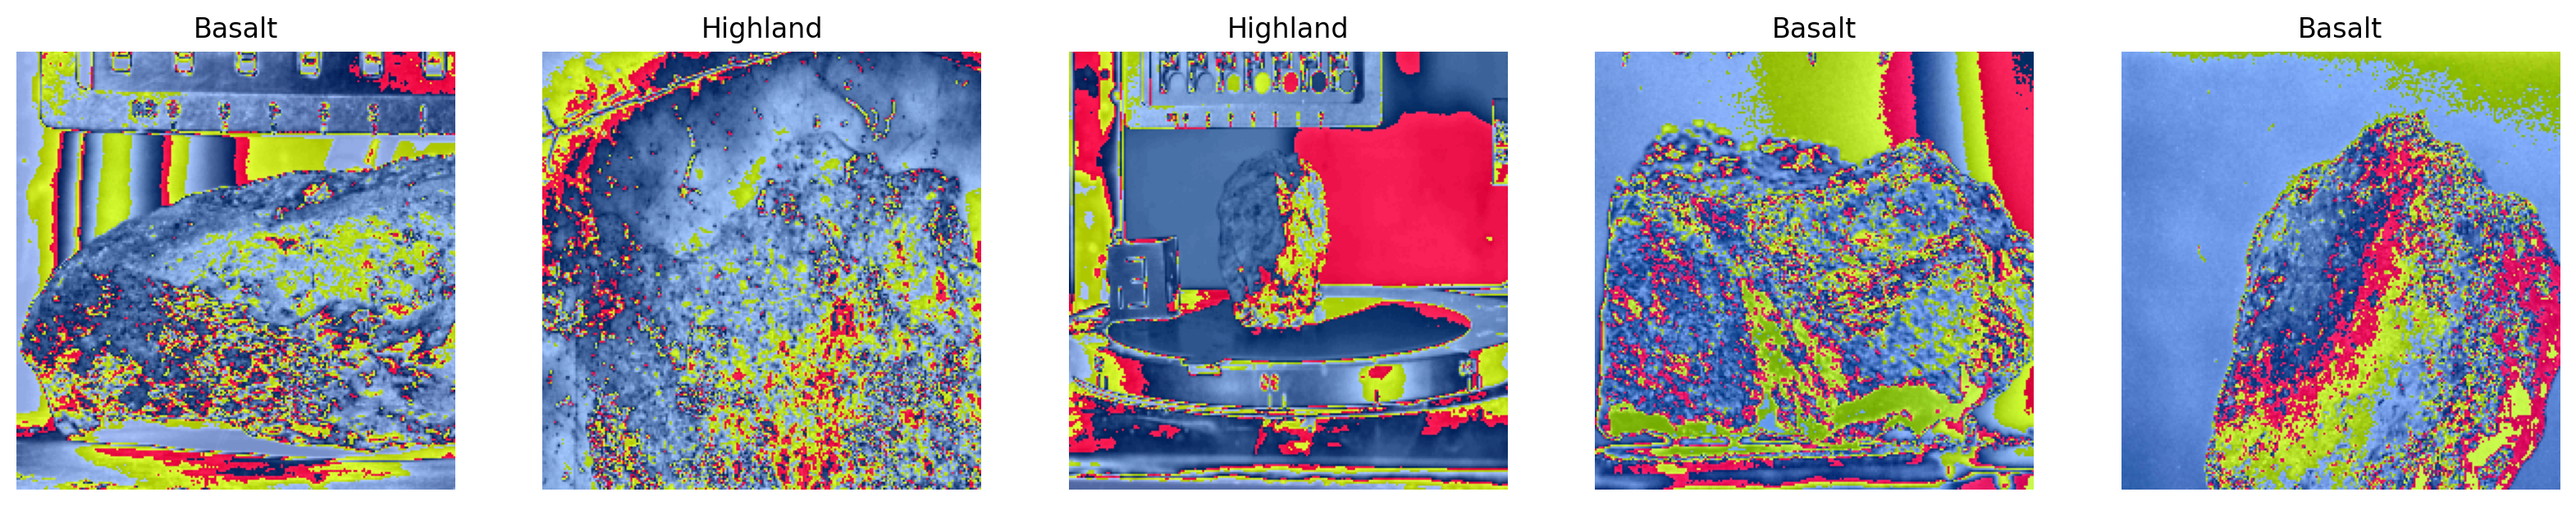

In [6]:
# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = torchvision.transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))
# 학습 데이터의 class 리스트를 얻는다.
classes = train_loader.dataset.classes
# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)) :
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
# 주피터 노트북에 이미지를 표시한다.
plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, learning_rate=0.001, batch_size=16, num_epochs=10):
        super(SimpleCNN, self).__init__()
        self._num_classes = num_classes
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        self._num_epochs = num_epochs

        self.model = torchvision.models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # 학습 및 검증 손실 기록용 리스트
        self.train_losses = []
        self.val_losses = []

    @property
    def learning_rate(self):
        return self._learning_rate

    @property
    def num_classes(self):
        return self._num_classes

    @property
    def batch_size(self):
        return self._batch_size

    @property
    def num_epochs(self):
        return self._num_epochs

    def forward(self, x):
        return self.model(x)

    def train_model(self, train_loader, val_loader, criterion, optimizer, num_epochs=None):
        if num_epochs is None:
            num_epochs = self._num_epochs
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            self.train_losses.append(epoch_loss)  # 학습 손실 저장
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
            val_loss = self.evaluate(val_loader, criterion)
            self.val_losses.append(val_loss)  # 검증 손실 저장

    def evaluate(self, val_loader, criterion):
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(val_loader.dataset)
        accuracy = 100 * correct / total
        print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
        return epoch_loss  # 검증 손실 반환

In [9]:
import random
import os
CFG = {
    'SEED': 42,
    'NUM_CLASSES': 2,
    'LEARNING_RATE': 0.001,
    'BATCH_SIZE': 16,
    'NUM_EPOCHS': 10
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED'])

/workspaces/yohaim/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/yohaim/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.1767
Validation Loss: 0.5629, Accuracy: 58.87%
Epoch [2/10], Loss: 0.1221
Validation Loss: 0.5450, Accuracy: 43.55%
Epoch [3/10], Loss: 0.1206
Validation Loss: 0.5015, Accuracy: 60.48%
Epoch [4/10], Loss: 0.1005
Validation Loss: 0.4159, Accuracy: 85.48%
Epoch [5/10], Loss: 0.0803
Validation Loss: 0.4089, Accuracy: 66.94%
Epoch [6/10], Loss: 0.0771
Validation Loss: 0.3818, Accuracy: 70.97%
Epoch [7/10], Loss: 0.0725
Validation Loss: 0.3254, Accuracy: 82.26%
Epoch [8/10], Loss: 0.0546
Validation Loss: 0.2940, Accuracy: 92.74%
Epoch [9/10], Loss: 0.0779
Validation Loss: 0.2964, Accuracy: 92.74%
Epoch [10/10], Loss: 0.0496
Validation Loss: 0.2590, Accuracy: 93.55%


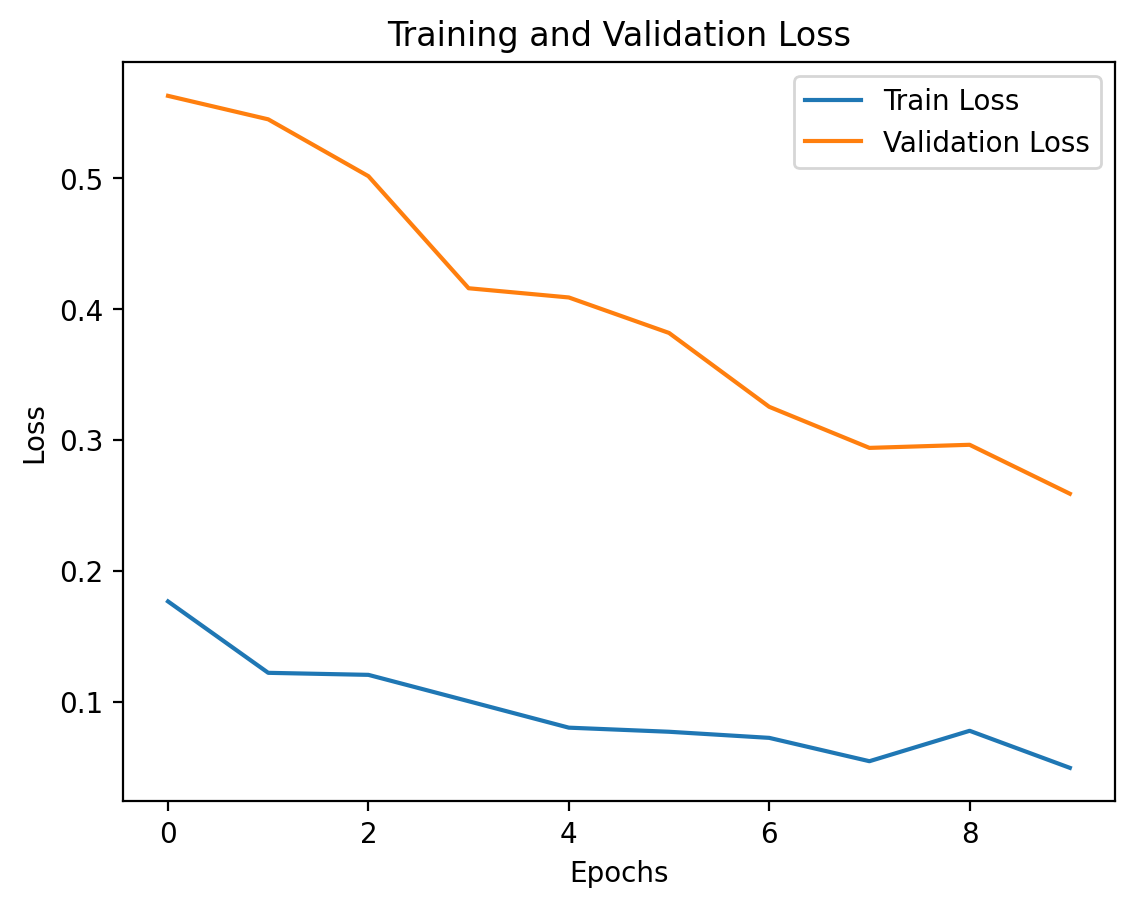

In [10]:
model = SimpleCNN(
    num_classes=CFG['NUM_CLASSES'],
    learning_rate=CFG['LEARNING_RATE'],
    batch_size=CFG['BATCH_SIZE'],
    num_epochs=CFG['NUM_EPOCHS']
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.fc.parameters(), lr=model.learning_rate)
model.train_model(train_loader, val_loader, criterion, optimizer, num_epochs=model.num_epochs)

# 학습 및 검증 손실 그래프 그리기
plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()